# 20-1. 들어가며

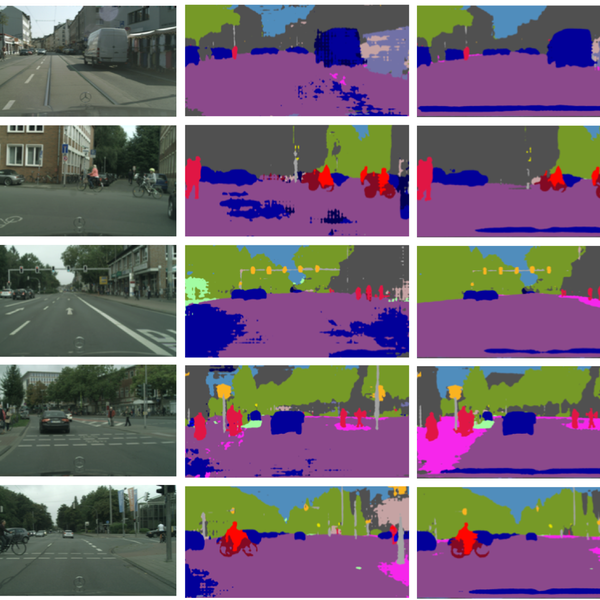
https://github.com/wasidennis/AdaptSegNet

이번 시간에는 Semantic Segmentation(시맨틱 세그멘테이션) 을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 모델을 만들어보는 시간을 갖겠습니다. 앞서 강의 노드에서는 Semantic Segmentation을 위한 다양한 모델을 배워보았습니다. 이번 시간에는 U-Net을 사용해서 이미지가 입력되면 도로의 영역을 Segmentation 하는 모델을 만들어보겠습니다.

최종적으로 만들어 볼 모델은 아래와 같습니다! 입력 이미지 위에 도로 영역으로 인식한 영역을 흰색으로 오버레이 한 이미지입니다.

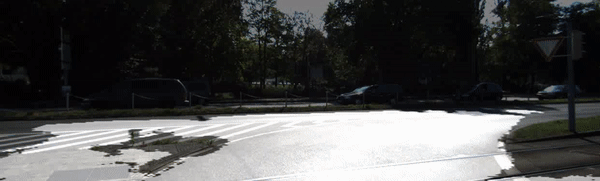

### 학습내용
---
2. 시맨틱 세그멘테이션 데이터셋
- Semantic Segmentation 학습을 위한 KITTI Dataset을 준비합니다.
3. 시맨틱 세그멘테이션 모델
- U-Net model을 작성합니다.
4. 시맨틱 세그멘테이션 모델 시각화
- 학습된 결과를 시각화합니다.

### 실습목표
---
- 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
- 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
- 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.


# 20-2. 시맨틱 세그멘테이션 데이터셋

### 이미지, 데이터 가져오기
---
먼저 시맨틱 세그멘테이션(semantic segmentation) 으로 도로의 영역을 분리하기 위해서는 도로의 영역을 라벨로 가진 데이터셋을 가지고 학습할 수 있도록 파싱 해야 합니다. 아래 링크를 통해서 물체 검출(object detection)으로 사용했던 KITTI 데이터셋의 세그멘테이션 데이터 를 다운로드합니다.

데이터 출처: http://www.cvlibs.net/datasets/kitti/eval_semantics.php

cloud shell에서 아래 명령어를 실행해 주세요

```bash
$ mkdir -p ~/aiffel/semantic_segmentation/data
$ ln -s  ~/data/* ~/aiffel/semantic_segmentation/data/
```

아래는 데이터셋에서 확인할 수 있는 이미지와 라벨입니다. 지금까지 보던 라벨 데이터와 다르게 세그멘테이션 데이터는 이미지 형태의 라벨로 되어있습니다.

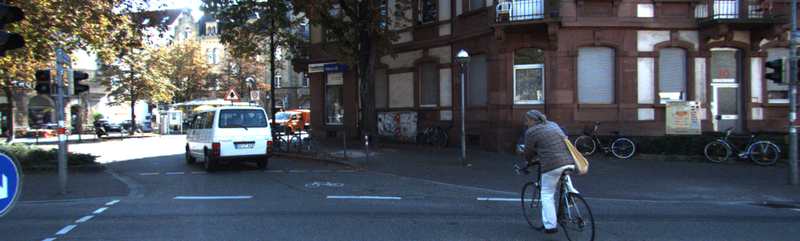
[KITTI 데이터셋]  

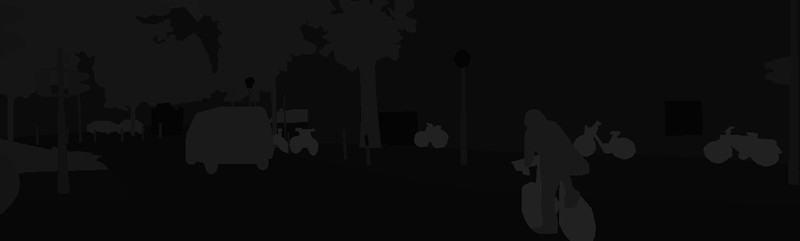
[KITTI 데이터셋 segmentation]  

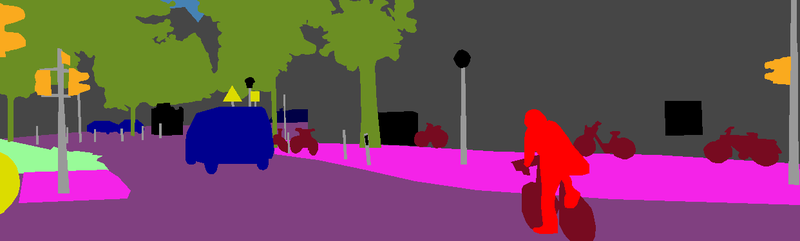
[KITTI 데이터셋 segmentation_rgb]  

#### Q. 시맨틱 세그멘테이션의 이미지 라벨의 각 pixel 값은 의미를 갖습니다. 그렇다면 오늘 우리가 시맨틱 세그멘테이션으로 찾아내야 할 도로의 label은 어떤 값일까요?
7


### 데이터 로더(data loader) 만들기
---
이제 이미지와 데이터셋이 주어졌으니 모델을 학습시킬 수 있는 데이터 로더(data loader)를 만들어봅시다. 로더는 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱 해야 합니다.

이때 데이터 로더에 augmentation 을 적용해 봅시다. 오늘은 파이썬에서 많이 사용되는 albumentations을 사용해 보겠습니다. 하지만 Augmentation의 경우 imgaug 등 다른 라이브러리를 활용하셔도 됩니다.

```
$ pip list | grep albumentations
```

또한 학습셋의 일정량을 검증 데이터셋(validation dataset) 으로 활용할 수 있도록 해야 합니다.

구현을 할 때는 아래 자료를 참고해 보세요.

- Keras Sequence에 기반한 Dataloader https://hwiyong.tistory.com/241
- Albumentation을 적용한 Keras sequence https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac  

만든 후에는 직접 데이터셋이 잘 파싱 되어 나오는지 꼭 확인해보세요. 데이터셋에 오류가 없어야 성능이 안 나오더라도 문제를 찾아내기 쉽습니다.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


Albumentation 의 사용법을 간단히 알아보겠습니다. 아래는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용예입니다. imgaug의 Sometimes()와 유사한 기능입니다.

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

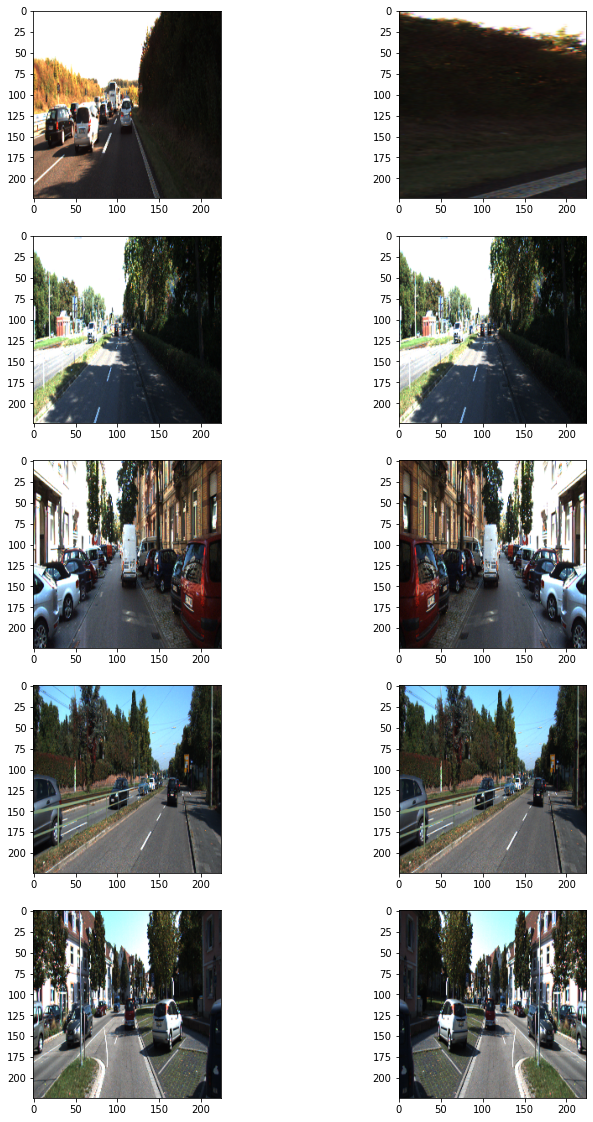

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지

plt.show()

이제 데이터셋을 구성해 봅시다. 이번에는 tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해 보겠습니다.

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                 dir_path,
                 batch_size=8, # batch size 16 -> 8 로 수정
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                        index*self.batch_size:
                        (index + 1)*self.batch_size
                        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# 20-3. 시맨틱 세그멘테이션 모델

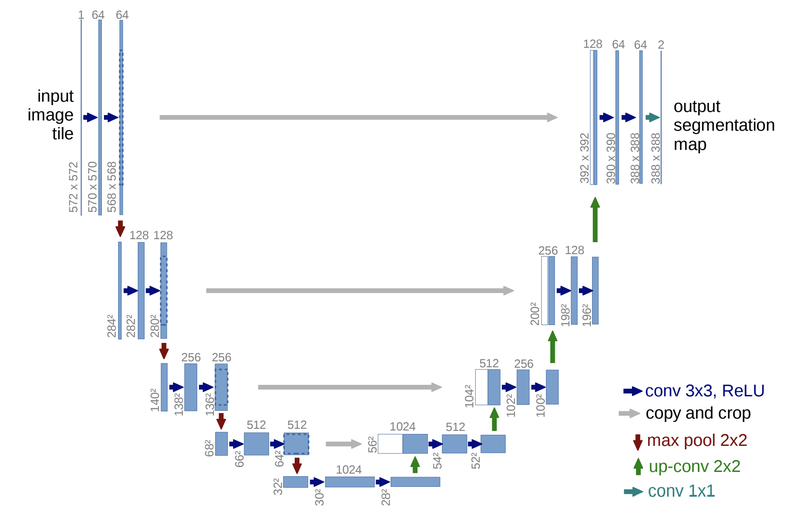

### 모델 구조 만들기
---
시맨틱 세그멘테이션을 위한 모델을 만들어주세요. 세그멘테이션 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현해 봅시다.

이때 입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만들어주세요.

사용에 필요한 레이어와 연산은 다음과 같습니다. 그리고 필요에 따라서 Dropout 등의 다른 레이어를 적용해 보세요.

- Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

In [6]:
def build_model(input_shape=(224, 224, 3)):
    """
    U-Net 모델 구축 함수 (binary_crossentropy에 맞게 수정)

    Parameters:
        input_shape (tuple): 입력 이미지의 크기 (H, W, C)
    
    Returns:
        model (tf.keras.Model): U-Net 모델
    """
    inputs = Input(input_shape)
    
    # Contracting Path (Encoder)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    b = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    b = Conv2D(1024, (3, 3), activation='relu', padding='same')(b)
    
    # Expansive Path (Decoder)
    u5 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(b)
    u5 = concatenate([u5, c4])
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    
    # 최종 출력 레이어 (이진 분류를 위해 채널 수 = 1, sigmoid 활성화)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

### 모델 학습하기
---
이제 모델을 만들었으니 위에서 만들어본 데이터셋과 학습을 해봅시다! (모델 학습에 상당한 시간이 소요됨으로 학습이 잘 진행되는지 확인해 보시고 다음 스텝으로 넘어가셔서 이미 학습된 모델을 사용하셔도 됩니다.)

In [7]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs= 1 # 100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

11/11 [==============================] - 24s 657ms/step - loss: 0.6886 - val_loss: 0.6790


# 20-4. 시맨틱 세그멘테이션 모델 시각화

이번에는 학습한 모델의 결과를 눈으로 확인해 볼 차례입니다. 우선 이전 스텝에서 저장한 모델이나 제공된 모델을 다음 코드를 통해 불러와 주세요.

In [8]:
# 미리 준비한 모델을 불러오려면 아래 주석을 해제하세요
model_path = dir_path + '/seg_model_unet.h5' 

model = tf.keras.models.load_model(model_path)

테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록 모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들어주세요!

이때 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(overray) 해 주세요. PIL 패키지를 사용하신다면 Image.blend를 활용하실 수 있습니다.

get_output이라는 이름의 함수로 만들어 주세요.

In [17]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

위에서 작성한 함수를 이용해 시각화를 해봅시다.

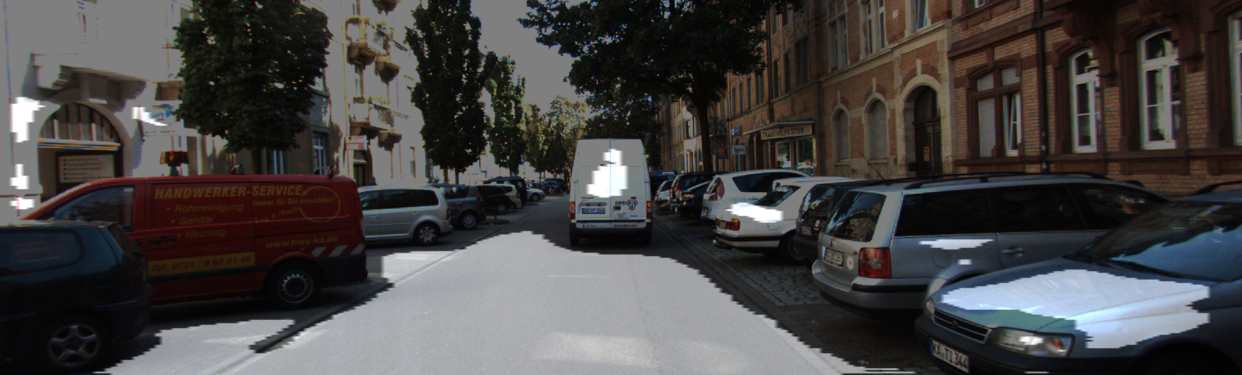

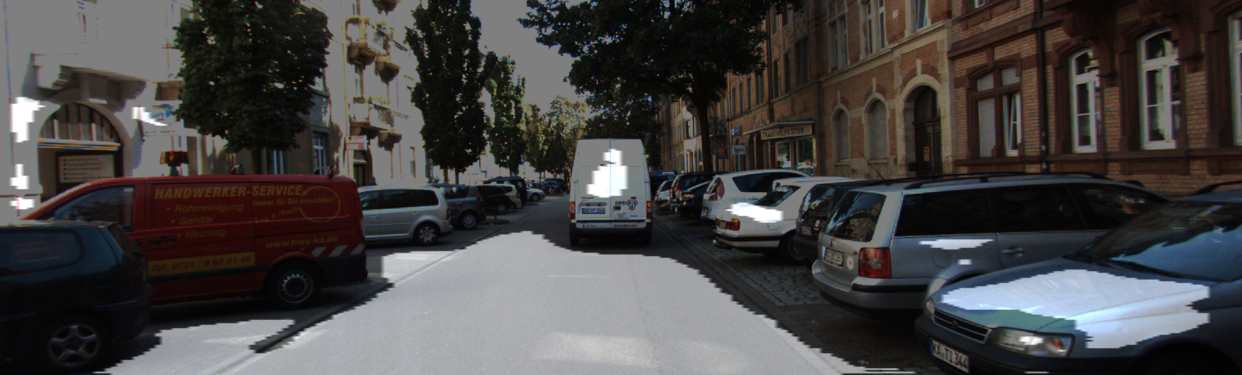

In [18]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하게 됩니다. IoU를 계산하는 방법은 지난 시간에 소개한 바 있으므로 해당 내용을 활용하여 구현해 보겠습니다.

IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 각각을 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현해 보겠습니다. 위에 구현했던 get_output을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현해 봅시다.

In [22]:
def calculate_iou_score(target, prediction):
    """
    IoU (Intersection over Union) 점수를 계산합니다.

    Parameters:
        target (np.ndarray): 실제 레이블 이미지 (binary mask: 0 또는 1)
        prediction (np.ndarray): 예측된 레이블 이미지 (binary mask: 0 또는 1)

    Returns:
        float: IoU 점수
    """
    # Intersection (교집합): target과 prediction 모두 1인 부분
    intersection = np.logical_and(target, prediction).sum()
    
    # Union (합집합): target과 prediction 중 하나라도 1인 부분
    union = np.logical_or(target, prediction).sum()
    
    # IoU Score 계산
    iou_score = float(intersection) / float(union) if union != 0 else 0.0
    print('IoU : %f' % iou_score )
    return iou_score

In [23]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

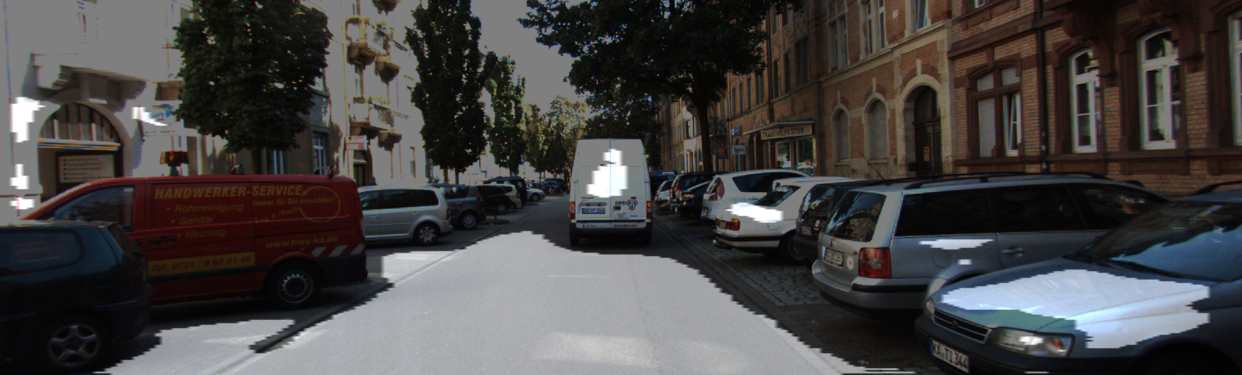

IoU : 0.647032


0.6470318061775175

In [24]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)